In [1]:
import os
import sys
import re
import math
import string
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from sklearn.feature_selection import f_classif, mutual_info_classif
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pathlib import Path
from collections import Counter
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV
)
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_recall_fscore_support
)
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy.sparse import hstack, csr_matrix

In [2]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

# proporção de stopword
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lpl_z\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lpl_z\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lpl_z\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train_rules = pd.read_csv("data/train.csv")
train_rules.head()

,id,real_text_id
0,0,1
1,1,2
2,2,1
3,3,2
4,4,2


In [4]:
def cria_caminho_article(text_id, article):
    # Função para criar o caminho de leitura
    caminho = f"data/train/article_{article}/file_{text_id}.txt"
    return caminho
    
def leitura_arquivo(file_path):
    # Função para ler o caminho criado
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().strip()
    return text

In [5]:
# Criação do dataset de treino
train_rules['fake_text_id'] = train_rules['real_text_id'].apply(lambda x: 2 if x == 1 else 1)
train_rules['article'] = train_rules['id'].apply(lambda x: str(x).zfill(4))

train_rules['real_text_file'] = train_rules[['real_text_id', 'article']].apply(lambda x: cria_caminho_article(x['real_text_id'], x['article']), axis=1)
train_rules['fake_text_file'] = train_rules[['fake_text_id', 'article']].apply(lambda x: cria_caminho_article(x['fake_text_id'], x['article']), axis=1)

train_rules['real_text'] = train_rules['real_text_file'].apply(leitura_arquivo)
train_rules['fake_text'] = train_rules['fake_text_file'].apply(leitura_arquivo)

In [6]:
train_rules.head()

,id,real_text_id,fake_text_id,article,real_text_file,fake_text_file,real_text,fake_text
0,0,1,2,0000,data/train/article_0000/file_1.txt,data/train/article_0000/file_2.txt,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...
1,1,2,1,0001,data/train/article_0001/file_2.txt,data/train/article_0001/file_1.txt,The project aims to achieve an accuracy level ...,China\nThe goal of this project involves achie...
2,2,1,2,0002,data/train/article_0002/file_1.txt,data/train/article_0002/file_2.txt,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...
3,3,2,1,0003,data/train/article_0003/file_2.txt,data/train/article_0003/file_1.txt,The importance for understanding how stars evo...,China\nThe study suggests that multiple star s...
4,4,2,1,0004,data/train/article_0004/file_2.txt,data/train/article_0004/file_1.txt,Analyzing how fast stars rotate within a galax...,Dinosaur Rex was excited about his new toy set...


In [7]:
# Normalização do dataset
# Artigos apenas com os textos reais
df_real = train_rules[['article', 'real_text']].copy()
df_real.columns = ['article', 'texto']  # Padroniza nomes
df_real['label'] = 1

# Artigos apenas com os textos fakes
df_fake = train_rules[['article', 'fake_text']].copy()
df_fake.columns = ['article', 'texto']
df_fake['label'] = 0

# Concatenar os dois dataframes (real + fake)
df_completo = pd.concat([df_real, df_fake], ignore_index=True)

# Exibir resultado
df_completo.head()

,article,texto,label
0,0000,The VIRSA (Visible Infrared Survey Telescope A...,1
1,0001,The project aims to achieve an accuracy level ...,1
2,0002,Scientists can learn about how galaxies form a...,1
3,0003,The importance for understanding how stars evo...,1
4,0004,Analyzing how fast stars rotate within a galax...,1


In [8]:
n_artigo = '0090'
print(f"Label: {df_completo[df_completo['article']==n_artigo].label.iloc[0]}")
df_completo[df_completo['article']==n_artigo].texto.iloc[0]

Label: 1


'A key focus of modern cosmology is to understand how galaxies form. The current standard model suggests that structure developed from small fluctuations in matter during recombination (about one part in 105, as noted in Cosmic Microwave Background experiments) through hierarchical mergers of dark matter. Over time, the gravity of the largest mass concentrations became strong enough to attract and gather the gas necessary for forming early galaxies. It is believed that the first stars generated ultraviolet light, which reionized the Universe, ending the Dark Ages that followed recombination. Advances in technology are helping astronomers bridge the gap between CMB data from 380,000 years after the Big Bang and initial galaxy observations. Utilizing the imaging capabilities of the Advanced Camera for Surveys (ACS) on the Hubble Space Telescope and the spectroscopic abilities of the FORS2 instrument at the ESO/VLT, our team has identified a significant number of galaxies at redshifts up 

In [9]:
print(f"Label: {df_completo[df_completo['article']==n_artigo].label.iloc[1]}")
df_completo[df_completo['article']==n_artigo].texto.iloc[1]

Label: 0


"A main focus of modern cosmology is to understand how galaxies form. The current standard model suggests that structure developed through hierarchical mergers of dark matter concentrations, starting from initial tiny fluctuations in matter, about one part in 100,000 at recombination, as shown in CMB experiments. Over time, large mass aggregates' gravity was strong enough to attract and concentrate gas, leading to the birth of early galaxies. The first stars are believed to have emitted the ultraviolet light necessary to reionize the Universe, marking the end of the Dark Ages that followed recombination. Astronomers are bridging the time gap between CMB measurements, which represent the Universe 380,000 years after the Big Bang, and pale galaxies’ observations due to progressively advanced instruments. Utilizing the imaging capabilities of the Advanced Camera for Surveys (ACS) aboard the Hubble Space Telescope and the spectroscopic power of the FORS2 instrument at the ESO/VLT, our team

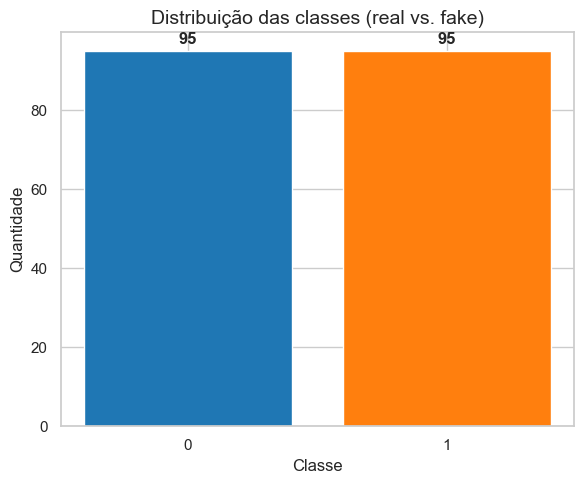

In [10]:
# Estilo visual (opcional)
sns.set(style='whitegrid')

# Obtem contagens
contagens = df_completo['label'].value_counts().sort_index()

# Cria figura e eixo
fig, ax = plt.subplots(figsize=(6, 5))  # Altere o tamanho aqui se quiser

# Cores personalizadas
cores = ['#1f77b4', '#ff7f0e']  # azul / laranja

# Plot com altura ajustável
bars = ax.bar(contagens.index.astype(str), contagens.values, color=cores)

# Adiciona os valores no topo das barras
for bar in bars:
    altura = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, altura + 1,
            f'{int(altura)}', ha='center', va='bottom', fontsize=12, weight='bold')

# Labels e título
ax.set_xlabel('Classe', fontsize=12)
ax.set_ylabel('Quantidade', fontsize=12)
ax.set_title('Distribuição das classes (real vs. fake)', fontsize=14)

plt.tight_layout()
plt.show()

In [11]:
def extract_features(text):
    words = word_tokenize(text.lower())
    word_count = len(words)
    non_latin = len(re.findall(r'[^\x00-\x7F]', text))
    punct_count = sum(1 for c in text if c in string.punctuation)
    num_lines = text.count('\n')
    stop_count = sum(1 for w in words if w in stopwords_set)
    long_words = sum(1 for w in words if len(w) > 15)
    ent = entropy(text)
    num_sentences = text.count('.') + text.count('!') + text.count('?') + text.count('-')
    avg_sent_len = word_count / (num_sentences + 1)

    return {
        'texto_len': word_count,
        'non_latin_chars': non_latin,
        'num_pontuacao': punct_count,
        'num_linhas': num_lines,
        'stopword_ratio': stop_count / word_count if word_count > 0 else 0,
        'long_words': long_words,
        'entropia': ent,
        'num_sentencas': num_sentences,
        'avg_sentence_len': avg_sent_len
    }


def entropy(text):
    if len(text) == 0:
        return 0
    probs = [v / len(text) for v in Counter(text).values()]
    return -sum(p * math.log2(p) for p in probs if p > 0)



In [12]:
feature_df = df_completo['texto'].apply(extract_features).apply(pd.Series)
df_completo = pd.concat([df_completo, feature_df], axis=1)

In [13]:
df_completo.head()

,article,texto,label,texto_len,non_latin_chars,num_pontuacao,num_linhas,stopword_ratio,long_words,entropia,num_sentencas,avg_sentence_len
0,0000,The VIRSA (Visible Infrared Survey Telescope A...,1,322.0,0.0,32.0,0.0,0.186335,0.0,4.468973,14.0,21.466667
1,0001,The project aims to achieve an accuracy level ...,1,153.0,1.0,23.0,0.0,0.248366,0.0,4.430374,9.0,15.300000
2,0002,Scientists can learn about how galaxies form a...,1,171.0,2.0,16.0,1.0,0.274854,0.0,4.299045,8.0,19.000000
3,0003,The importance for understanding how stars evo...,1,271.0,0.0,17.0,1.0,0.265683,0.0,4.299974,8.0,30.111111
4,0004,Analyzing how fast stars rotate within a galax...,1,138.0,0.0,19.0,0.0,0.224638,0.0,4.263312,5.0,23.000000


In [14]:
df_completo.describe().T

,count,mean,std,min,25%,50%,75%,max
label,190.0,0.500000,0.501321,0.0,0.000000,0.500000,1.000000,1.000000
texto_len,190.0,377.805263,468.223332,0.0,196.750000,265.500000,371.250000,5553.000000
non_latin_chars,190.0,138.957895,494.870330,0.0,0.000000,1.000000,4.000000,5007.000000
num_pontuacao,190.0,81.447368,180.418781,0.0,23.000000,38.000000,60.750000,2156.000000
num_linhas,190.0,9.642105,24.954314,0.0,0.000000,2.000000,6.000000,250.000000
stopword_ratio,190.0,0.284397,0.099705,0.0,0.278858,0.308992,0.340319,0.485714
long_words,190.0,9.147368,33.428267,0.0,0.000000,0.000000,1.000000,363.000000
entropia,190.0,4.547477,0.640290,0.0,4.400106,4.477014,4.571949,5.947896
num_sentencas,190.0,31.094737,54.646158,0.0,9.000000,16.000000,24.000000,557.000000
avg_sentence_len,190.0,16.006252,5.944302,0.0,12.850000,15.472222,18.819444,40.000000


In [15]:
df_completo.groupby('label')[[
    'texto_len', 'non_latin_chars', 'num_pontuacao',
    'num_linhas', 'stopword_ratio', 'long_words',
    'entropia', 'num_sentencas', 'avg_sentence_len'
]].describe().T

label                            0           1
texto_len        count   95.000000   95.000000
                 mean   450.473684  305.136842
                 std    644.063081  123.723234
                 min      0.000000  106.000000
                 25%    166.500000  222.000000
...                            ...         ...
avg_sentence_len min      0.000000    8.256410
                 25%     10.172059   14.387701
                 50%     15.000000   16.333333
                 75%     17.684524   19.416304
                 max     36.875000   40.000000

[72 rows x 2 columns]

In [16]:
# Mostra todas as linhas e colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Agora sim a visualização completa:
df_completo.groupby('label')[[
    'texto_len', 'non_latin_chars', 'num_pontuacao',
    'num_linhas', 'stopword_ratio', 'long_words',
    'entropia', 'num_sentencas', 'avg_sentence_len'
]].describe().T



label                             0           1
texto_len        count    95.000000   95.000000
                 mean    450.473684  305.136842
                 std     644.063081  123.723234
                 min       0.000000  106.000000
                 25%     166.500000  222.000000
                 50%     249.000000  275.000000
                 75%     418.500000  361.000000
                 max    5553.000000  762.000000
non_latin_chars  count    95.000000   95.000000
                 mean    274.989474    2.926316
                 std     674.522408    3.898287
                 min       0.000000    0.000000
                 25%       0.000000    0.000000
                 50%       0.000000    2.000000
                 75%       4.500000    4.000000
                 max    5007.000000   20.000000
num_pontuacao    count    95.000000   95.000000
                 mean    115.389474   47.505263
                 std     249.570409   28.881222
                 min       0.000000   13.000000
                 25%      20.000000   27.000000
                 50%      33.000000   43.000000
                 75%      57.000000   61.000000
                 max    2156.000000  163.000000
num_linhas       count    95.000000   95.000000
                 mean     15.294737    3.989474
                 std      34.150130    4.609183
                 min       0.000000    0.000000
                 25%       0.000000    0.000000
                 50%       1.000000    2.000000
                 75%       5.500000    7.000000
                 max     250.000000   19.000000
stopword_ratio   count    95.000000   95.000000
                 mean      0.252523    0.316272
                 std       0.128015    0.039327
                 min       0.000000    0.186335
                 25%       0.249567    0.292189
                 50%       0.301205    0.324742
                 75%       0.334471    0.343361
                 max       0.485714    0.395918
long_words       count    95.000000   95.000000
                 mean     17.852632    0.442105
                 std      45.748379    0.834314
                 min       0.000000    0.000000
                 25%       0.000000    0.000000
                 50%       0.000000    0.000000
                 75%       2.000000    1.000000
                 max     363.000000    5.000000
entropia         count    95.000000   95.000000
                 mean      4.608106    4.486849
                 std       0.898071    0.101697
                 min       0.000000    4.263312
                 25%       4.382922    4.414429
                 50%       4.464607    4.494256
                 75%       4.613921    4.556778
                 max       5.947896    4.755636
num_sentencas    count    95.000000   95.000000
                 mean     43.842105   18.347368
                 std      74.680214    9.929291
                 min       0.000000    4.000000
                 25%       9.000000   11.000000
                 50%      14.000000   17.000000
                 75%      25.000000   23.000000
                 max     557.000000   47.000000
avg_sentence_len count    95.000000   95.000000
                 mean     14.666265   17.346239
                 std       6.430919    5.104830
                 min       0.000000    8.256410
                 25%      10.172059   14.387701
                 50%      15.000000   16.333333
                 75%      17.684524   19.416304
                 max      36.875000   40.000000

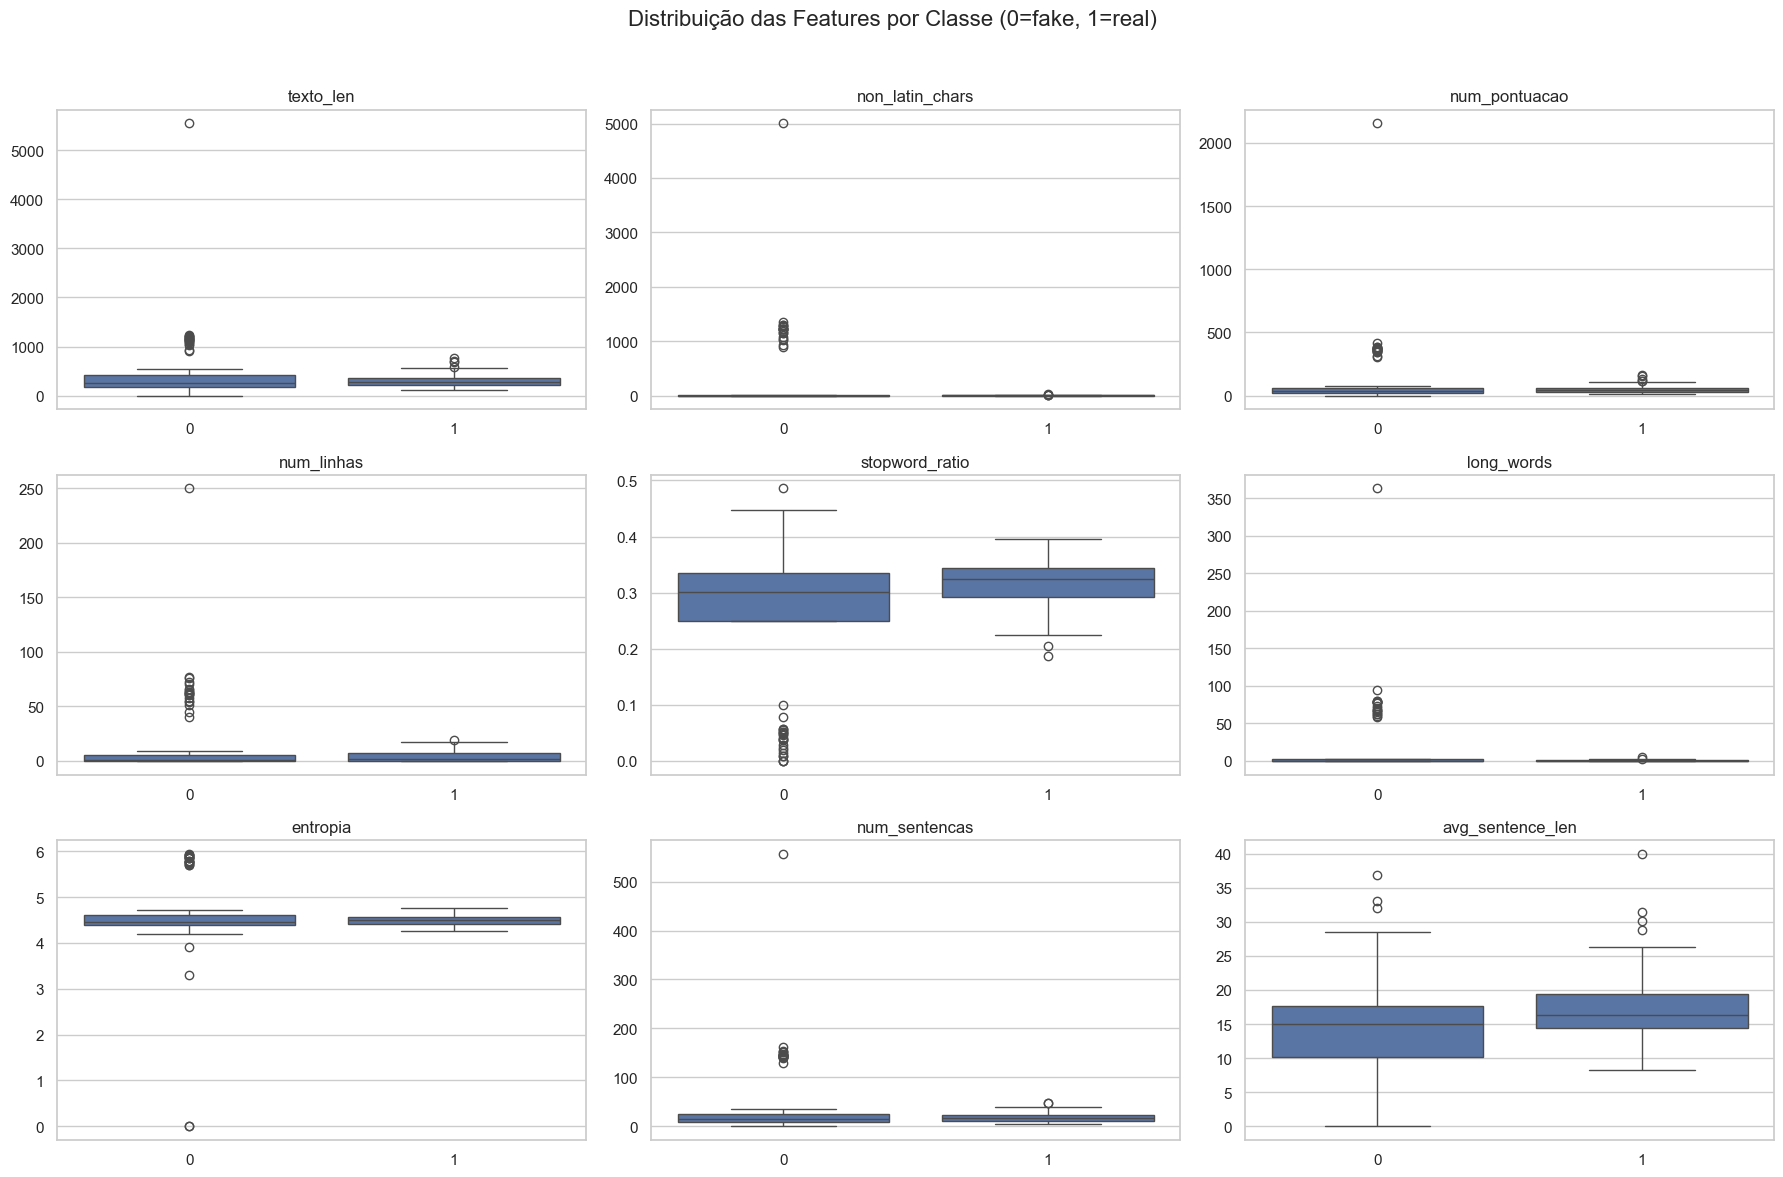

In [17]:
features = ['texto_len', 'non_latin_chars', 'num_pontuacao', 'num_linhas',
            'stopword_ratio', 'long_words', 'entropia', 'num_sentencas', 'avg_sentence_len']

# Grid 3x3
fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # (linhas, colunas)
fig.suptitle('Distribuição das Features por Classe (0=fake, 1=real)', fontsize=16)

for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.boxplot(x='label', y=feature, data=df_completo, ax=ax)
    ax.set_title(feature)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # ajuste para o título principal
plt.show()


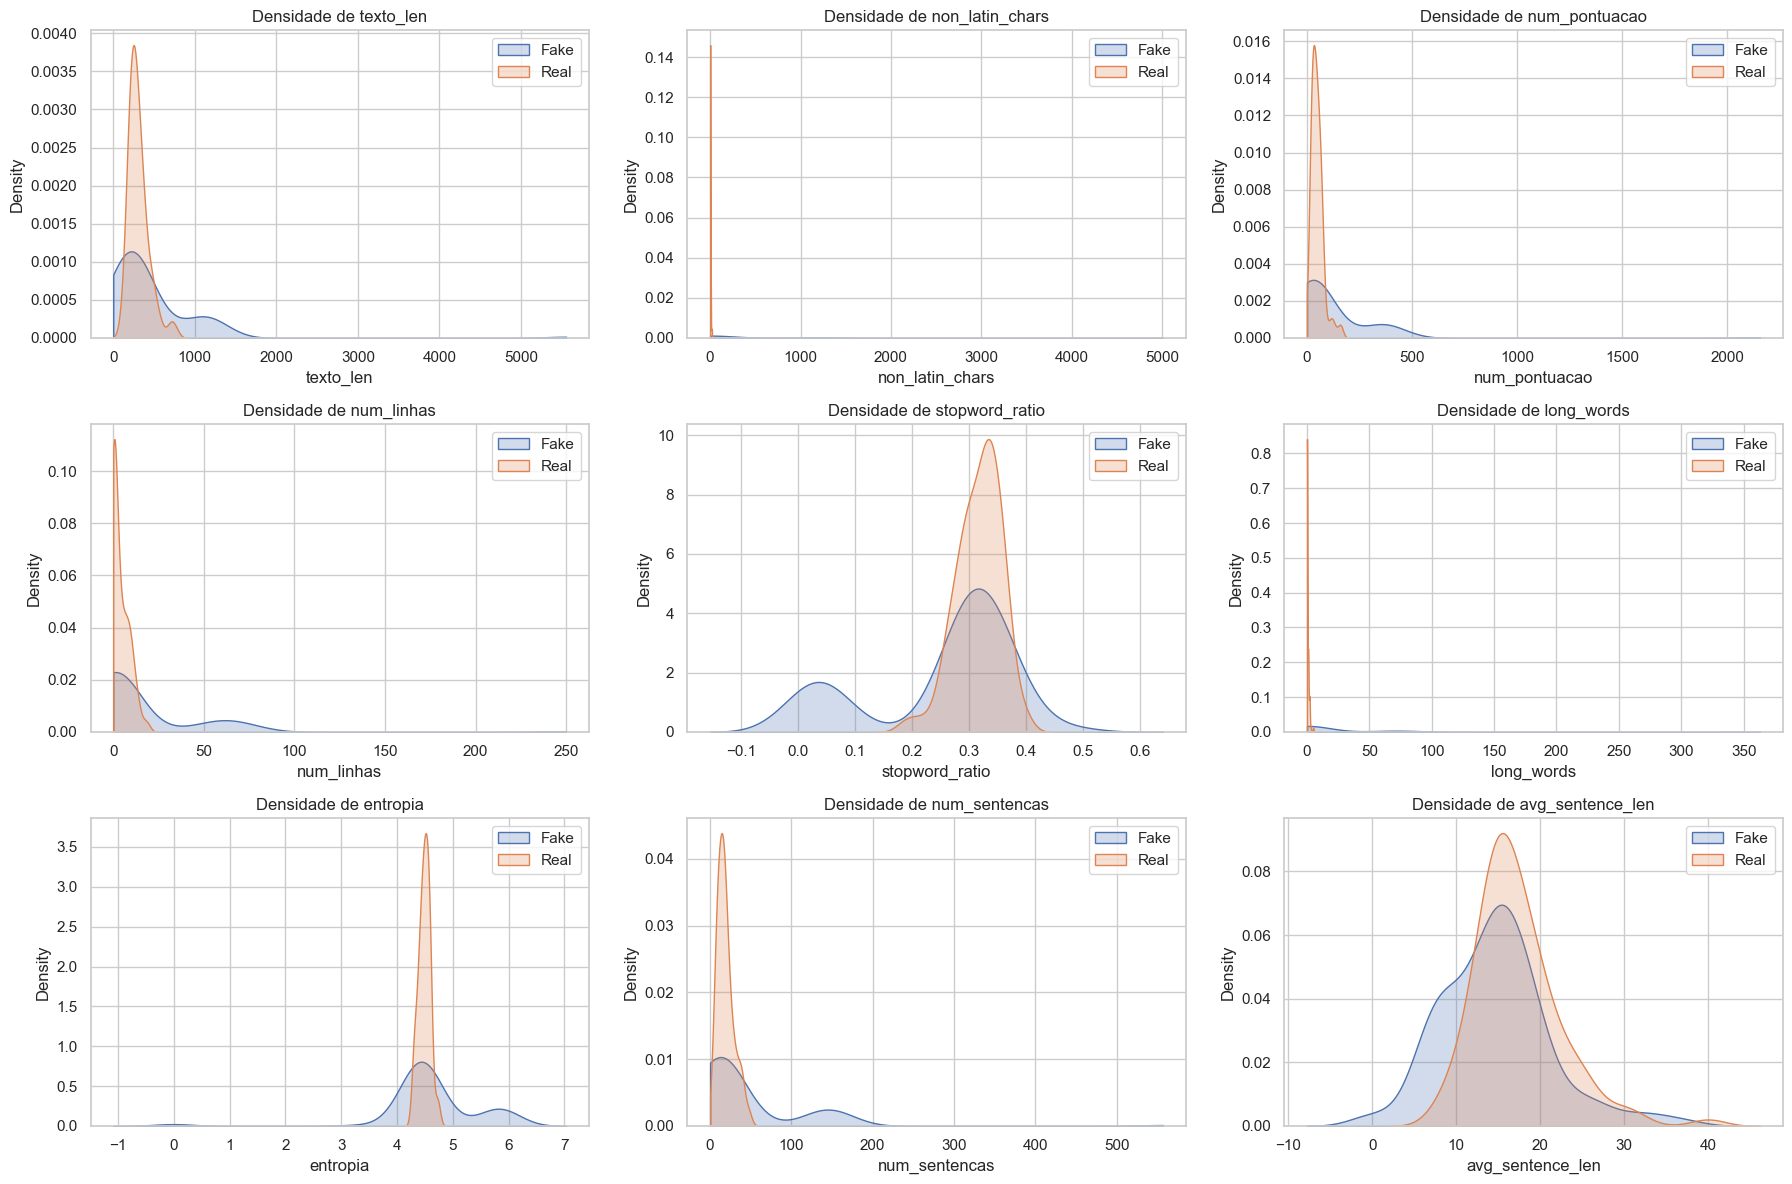

In [18]:
features = [
    'texto_len', 'non_latin_chars', 'num_pontuacao', 'num_linhas',
    'stopword_ratio', 'long_words', 'entropia', 'num_sentencas', 'avg_sentence_len'
]

# Define quais variáveis são contagens
clip_zero = {
    'texto_len', 'non_latin_chars', 'num_pontuacao', 'num_linhas',
    'long_words', 'num_sentencas'
}

# Configura grid
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    clip_range = (0, df_completo[feature].max()) if feature in clip_zero else None

    sns.kdeplot(data=df_completo[df_completo['label'] == 0], x=feature, label='Fake',
                fill=True, ax=ax, clip=clip_range)
    sns.kdeplot(data=df_completo[df_completo['label'] == 1], x=feature, label='Real',
                fill=True, ax=ax, clip=clip_range)

    ax.set_title(f'Densidade de {feature}')
    ax.legend()

# Remove subplots extras se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [19]:
X = df_completo[features]
y = df_completo['label']

# ANOVA F-value
f_vals, p_vals = f_classif(X, y)

# Mutual Information
mi_scores = mutual_info_classif(X, y, random_state=42)

ranking = pd.DataFrame({
    'feature': X.columns,
    'anova_f': f_vals,
    'anova_p': p_vals,
    'mutual_info': mi_scores
}).sort_values(by='mutual_info', ascending=False)

ranking

,feature,anova_f,anova_p,mutual_info
2,num_pontuacao,6.935815,0.009152,0.186087
0,texto_len,4.665312,0.032044,0.157858
3,num_linhas,10.224925,0.001626,0.124536
6,entropia,1.709938,0.192590,0.116423
1,non_latin_chars,15.454530,0.000119,0.106735
7,num_sentencas,10.879359,0.001163,0.103544
4,stopword_ratio,21.526614,0.000007,0.068978
5,long_words,13.754714,0.000274,0.043269
8,avg_sentence_len,10.120959,0.001715,0.027775


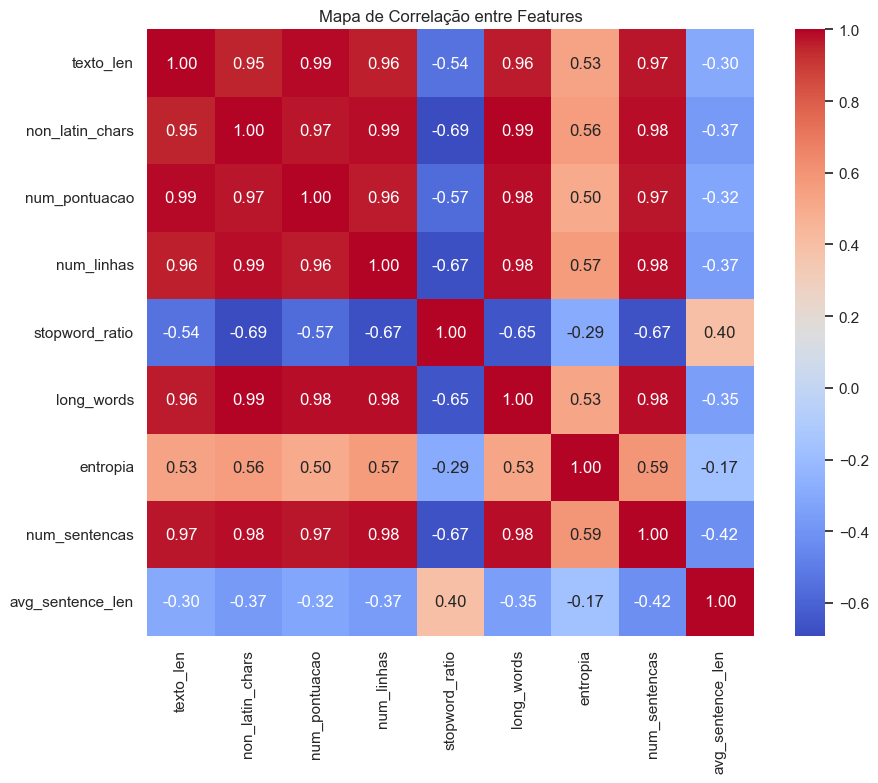

In [20]:
df_corr = df_completo[features]

# 2. Calcular a matriz de correlação
correlation_matrix = df_corr.corr()

# 3. Plotar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Mapa de Correlação entre Features")
plt.tight_layout()
plt.show()

In [21]:
# Apenas colunas úteis
colunas_uteis = ['article', 'texto', 'texto_len', 'stopword_ratio', 'entropia', 'label', 'avg_sentence_len']
df_final = df_completo[colunas_uteis].copy()
df_final.head()

,article,texto,texto_len,stopword_ratio,entropia,label,avg_sentence_len
0,0000,The VIRSA (Visible Infrared Survey Telescope A...,322.0,0.186335,4.468973,1,21.466667
1,0001,The project aims to achieve an accuracy level ...,153.0,0.248366,4.430374,1,15.300000
2,0002,Scientists can learn about how galaxies form a...,171.0,0.274854,4.299045,1,19.000000
3,0003,The importance for understanding how stars evo...,271.0,0.265683,4.299974,1,30.111111
4,0004,Analyzing how fast stars rotate within a galax...,138.0,0.224638,4.263312,1,23.000000


In [22]:
columns_x = ['texto_len', 'stopword_ratio', 'entropia', 'avg_sentence_len']
columns_y = 'label'
X = df_final[columns_x]
y = df_final[columns_y]

In [23]:
X.head()

,texto_len,stopword_ratio,entropia,avg_sentence_len
0,322.0,0.186335,4.468973,21.466667
1,153.0,0.248366,4.430374,15.300000
2,171.0,0.274854,4.299045,19.000000
3,271.0,0.265683,4.299974,30.111111
4,138.0,0.224638,4.263312,23.000000


In [24]:
# Shuffle dos dados
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# Vetorização TF-IDF
tfidf = TfidfVectorizer(max_features=500)
X_tfidf = tfidf.fit_transform(df_final['texto'])

# Normalização das features manuais
scaler = StandardScaler()
X_extra = scaler.fit_transform(df_final[columns_x])

# Combinação das features
from scipy.sparse import hstack, csr_matrix
X_combined = hstack([X_tfidf, X_extra])
X_combined = csr_matrix(X_combined)  # Permite indexação

y = df_final['label'].values

In [25]:
modelos = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for nome, modelo in modelos.items():
    accuracies, precisions, recalls, f1s = [], [], [], []

    for train_index, test_index in kf.split(X_combined, y):
        X_train, X_test = X_combined[train_index], X_combined[test_index]
        y_train, y_test = y[train_index], y[test_index]

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

        accuracies.append(acc)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    print(f"\n📌 Modelo: {nome}")
    print(f"Accuracy:  {np.mean(accuracies):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall:    {np.mean(recalls):.4f}")
    print(f"F1-score:  {np.mean(f1s):.4f}")


📌 Modelo: RandomForest
Accuracy:  0.6000
Precision: 0.6066
Recall:    0.6000
F1-score:  0.5944

📌 Modelo: XGBoost
Accuracy:  0.5632
Precision: 0.5652
Recall:    0.5632
F1-score:  0.5612

📌 Modelo: LogisticRegression
Accuracy:  0.5842
Precision: 0.5937
Recall:    0.5842
F1-score:  0.5717

📌 Modelo: SVM
Accuracy:  0.6263
Precision: 0.6805
Recall:    0.6263
F1-score:  0.5932


In [26]:
# 1. Definição do modelo e pipeline
svm = SVC(probability=True)

pipeline = Pipeline([
    ('clf', svm)
])

# 2. Parâmetros a testar
param_grid = {
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 'auto']  # só afeta kernel rbf
}

# 3. Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,  # usa todos os núcleos
    verbose=2
)

# 4. Executar GridSearch
grid.fit(X_combined, y)

# 5. Resultados
print("🔍 Melhor combinação de parâmetros:")
print(grid.best_params_)
print("\n📈 Melhor F1-score médio (validação cruzada):")
print(grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
🔍 Melhor combinação de parâmetros:
{'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

📈 Melhor F1-score médio (validação cruzada):
0.6541234309688398


In [27]:
# treinamento do melhor modelo
best_model = grid.best_estimator_

# 2. Reajustar (re-treinar) com todos os dados disponíveis
best_model.fit(X_combined, y)


,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True


In [28]:
# Dados de Submissão
data_path = Path.cwd() / 'data' / 'test'

# Coleta todas as subpastas (apenas diretórios)
pastas = [folder for folder in data_path.iterdir() if folder.is_dir()]

# Arquivos desejados por pasta
nomes_arquivos = ["file_1.txt", "file_2.txt"]

# Lista de caminhos completos para cada arquivo
arquivos = [pasta / nome for pasta in pastas for nome in nomes_arquivos]

# Exibir como DataFrame
df_arquivos = pd.DataFrame(arquivos, columns=["caminho_completo"])
df_arquivos.head()

,caminho_completo
0,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...
1,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...
2,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...
3,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...
4,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...


In [29]:
# Criação do dataframe de submissão
df_submission = df_arquivos.copy()

# Extração de colunas a partir do caminho
df_submission["texto"] = df_submission["caminho_completo"].apply(leitura_arquivo)
df_submission["article"] = df_submission["caminho_completo"].astype(str).str.extract(r'(article_\d{4})')
df_submission["file_id"] = df_submission["caminho_completo"].astype(str).str.extract(r'file_(\d)\.txt').astype(int)

# Visualização inicial
df_submission.head()


,caminho_completo,texto,article,file_id
0,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...,"""Music"" Music music music Music music Music mu...",article_0000,1
1,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...,Since its launch on Paranal observatory's Very...,article_0000,2
2,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...,underground exploration on SN's birth has prov...,article_0001,1
3,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...,SN 1987A provides valuable insights as newer o...,article_0001,2
4,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...,This research aimed to understand how star sha...,article_0002,1


In [30]:
# 1. Extrai features e concatena com df_submission
feature_df = df_submission["texto"].apply(extract_features).apply(pd.Series)
df_sub = pd.concat([df_submission, feature_df], axis=1)

# 2. Define as colunas úteis para validação/inferência (sem 'label', mas incluindo 'file_id')
colunas_uteis_validation = [col for col in colunas_uteis if col != 'label']
colunas_uteis_validation.append('file_id')

# 3. Seleciona apenas as colunas úteis
df_final_test = df_sub[colunas_uteis_validation].copy()

# 4. Visualização rápida
df_final_test.head()

,article,texto,texto_len,stopword_ratio,entropia,avg_sentence_len,file_id
0,article_0000,"""Music"" Music music music Music music Music mu...",277.0,0.339350,4.359483,25.181818,1
1,article_0000,Since its launch on Paranal observatory's Very...,185.0,0.254054,4.389842,30.833333,2
2,article_0001,underground exploration on SN's birth has prov...,188.0,0.218085,4.399438,20.888889,1
3,article_0001,SN 1987A provides valuable insights as newer o...,233.0,0.257511,4.450372,16.642857,2
4,article_0002,This research aimed to understand how star sha...,121.0,0.272727,4.292665,30.250000,1


In [31]:
# --- Vetorização e normalização das features de teste ---
# 1. TF-IDF do texto (usando vetorizer treinado)
X_text = tfidf.transform(df_final_test["texto"])

# 2. Normalização das features manuais (usando scaler treinado)
X_manual = scaler.transform(df_final_test[columns_x])  # columns_x já contém as colunas numéricas úteis

# 3. Combina texto e features manuais
X_combined = hstack([X_text, X_manual])

# --- Geração dos scores (probabilidades de ser classe 1) ---
df_final_test["score"] = best_model.predict_proba(X_combined)[:, 1]



In [32]:
# --- Geração do dataframe de submissão final ---
# 1. Seleciona, por artigo, o file_id com maior probabilidade de ser "real"
df_submission_result = df_final_test.loc[df_final_test.groupby("article")["score"].idxmax()].copy()

# 2. Renomeia para o formato exigido pela competição
df_submission_result = df_submission_result[["file_id"]].rename(columns={"file_id": "real_text_id"})

# 3. Cria coluna sequencial de IDs (começando de 1)
df_submission_result["id"] = range(1, len(df_submission_result) + 1)

# 4. Reorganiza as colunas
df_submission_result = df_submission_result[["id", "real_text_id"]]

# 5. Exporta o arquivo final de submissão
df_submission_result.to_csv("submission.csv", index=False)


In [36]:
df_sub.head()

,caminho_completo,texto,article,file_id,texto_len,non_latin_chars,num_pontuacao,num_linhas,stopword_ratio,long_words,entropia,num_sentencas,avg_sentence_len
0,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...,"""Music"" Music music music Music music Music mu...",article_0000,1,277.0,0.0,21.0,4.0,0.339350,0.0,4.359483,10.0,25.181818
1,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...,Since its launch on Paranal observatory's Very...,article_0000,2,185.0,0.0,19.0,2.0,0.254054,0.0,4.389842,5.0,30.833333
2,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...,underground exploration on SN's birth has prov...,article_0001,1,188.0,1.0,27.0,4.0,0.218085,0.0,4.399438,8.0,20.888889
3,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...,SN 1987A provides valuable insights as newer o...,article_0001,2,233.0,0.0,28.0,1.0,0.257511,0.0,4.450372,13.0,16.642857
4,C:\Users\lpl_z\OneDrive\Área de Trabalho\the_i...,This research aimed to understand how star sha...,article_0002,1,121.0,0.0,10.0,1.0,0.272727,0.0,4.292665,3.0,30.250000


In [37]:
df_submission_result.head()

,id,real_text_id
1,1,2
2,2,1
4,3,1
6,4,1
9,5,2
